In [1]:
import bayes3d as b
import trimesh
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
def open3d_mesh_to_trimesh(mesh):
    return trimesh.Trimesh(
        vertices=np.asarray(mesh.vertices),
        faces=np.asarray(mesh.triangles)
    )

I0000 00:00:1700612112.986499   12978 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.1, far=3.5
)
jax_renderer = JaxRenderer(intrinsics)

In [3]:
import os
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 10
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
mesh = b.utils.scale_mesh(m, 1.0/100.0)

In [4]:
def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

projection_matrix = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
self = jax_renderer
gt_z = 2.0

pose = b.transform_from_pos(jnp.array([0.0, 0.0, gt_z]))
object_pose = pose
vertices = mesh.vertices
faces = mesh.faces
final_mtx_proj = projection_matrix @ object_pose
posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
pos_clip_ja = xfm_points(vertices, final_mtx_proj)


def render(z):
    object_pose = b.transform_from_pos(jnp.array([0.0, 0.0, z]))
    final_mtx_proj = projection_matrix @ object_pose
    posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(vertices, final_mtx_proj)
    rast_out, rast_out_db = jax_renderer.rasterize(pos_clip_ja[None,...], faces, jnp.array([intrinsics.height, intrinsics.width]))
    # return rast_out[...,3],rast_out[...,3], rast_out.sum(), rast_out
    gb_pos,_ = jax_renderer.interpolate(posw[None,...], rast_out, faces, rast_out_db, jnp.array([0,1,2,3]))
    mask = rast_out[..., -1] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = xfm_points(gb_pos, pose)
    depth = depth.reshape(shape_keep)[..., 2] * -1
    return depth, mask, mask.sum(), rast_out[...,3]
    
jax.clear_caches()
render_jit = jax.jit(render)

def loss(z, gt_img):
    a,b,c,d = render(z)
    return jnp.abs(gt_img - a).mean()

grad_func = jax.value_and_grad(loss, argnums=(0,))
grad_func_jit = jax.jit(grad_func)

loss  0.0
loss  (Array(0., dtype=float32), (Array(0.01067336, dtype=float32, weak_type=True),))


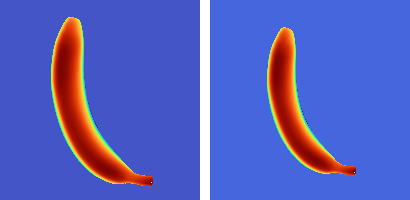

In [5]:
gt_z = 2.2
z = 2.5
gt_img,gt_mask,tmp,_ = render_jit(gt_z)
print("loss ", loss(gt_z, gt_img))
print("loss ", grad_func(gt_z, gt_img))
img, mask, _, _ = render_jit(z)
b.hstack_images([b.get_depth_image(gt_img[0,...]), b.get_depth_image(img[0,...]*1.0)])


In [6]:
z = 2.1
print("loss ", grad_func(z, gt_img))
print("loss jit ", grad_func_jit(z, gt_img))
print("loss ", jnp.abs(gt_img - render(z)[0]).mean())
print("loss ", jnp.abs(gt_img - render_jit(z)[0]).mean())

loss  (Array(0.00434917, dtype=float32), (Array(-0.0316381, dtype=float32, weak_type=True),))
loss jit  (Array(0.00434917, dtype=float32), (Array(-0.0316381, dtype=float32, weak_type=True),))
loss  0.004349175
loss  0.004349175


In [7]:
def xfm_points(points, matrix):
    points2 = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points2, matrix.T)

projection_matrix = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
self = jax_renderer
gt_z = 2.0

pose = b.transform_from_pos(jnp.array([0.0, 0.0, gt_z]))
object_pose = pose
vertices = mesh.vertices
faces = mesh.faces
final_mtx_proj = projection_matrix @ object_pose
posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
pos_clip_ja = xfm_points(vertices, final_mtx_proj)


def render(z):
    object_pose = b.transform_from_pos(jnp.array([0.0, 0.0, z]))
    final_mtx_proj = projection_matrix @ object_pose
    posw = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(vertices, final_mtx_proj)
    rast_out, rast_out_db = jax_renderer.rasterize(pos_clip_ja[None,...], faces, jnp.array([intrinsics.height, intrinsics.width]))
    return rast_out[...,3], None #rast_out[0,0,...]
    
jax.clear_caches()
render_jit = jax.jit(render)

In [8]:
gt_z = 2.2
z = 2.5
gt_img,_ = render_jit(gt_z)
print("loss jit", jnp.abs(gt_img - render_jit(z)[0]).mean())
print("loss ", jnp.abs(gt_img - render(z)[0]).mean())


loss jit 549.77185
loss  549.77185
